In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mayo-clinic-strip-ai/sample_submission.csv
/kaggle/input/mayo-clinic-strip-ai/train.csv
/kaggle/input/mayo-clinic-strip-ai/test.csv
/kaggle/input/mayo-clinic-strip-ai/other.csv
/kaggle/input/mayo-clinic-strip-ai/other/314263_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/0b33d7_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/54334d_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/84c279_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/cca9eb_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/880188_1.tif
/kaggle/input/mayo-clinic-strip-ai/other/2e3078_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/9daa03_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/065053_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/8acdfa_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/91530f_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/a2253f_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/f5eb8f_1.tif
/kaggle/input/mayo-clinic-strip-ai/other/ab830f_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/d17ad3_2.tif

In [2]:
import numpy as np 
import pandas as pd 
import os
import cv2
import keras.backend as K 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from pprint import pprint
from collections import defaultdict
import openslide
from openslide import OpenSlide
from glob import glob
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import GlobalMaxPooling2D
from keras.models import load_model

In [3]:
train_df = pd.read_csv("../input/mayo-clinic-strip-ai/train.csv")
test_df = pd.read_csv("../input/mayo-clinic-strip-ai/test.csv")
other_df = pd.read_csv("../input/mayo-clinic-strip-ai/other.csv")

In [4]:
train_df.shape

(754, 5)

In [5]:
test_df.shape

(4, 4)

In [6]:
train_df.head()

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    754 non-null    object
 1   center_id   754 non-null    int64 
 2   patient_id  754 non-null    object
 3   image_num   754 non-null    int64 
 4   label       754 non-null    object
dtypes: int64(2), object(3)
memory usage: 29.6+ KB


In [8]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# Avoid memory intensive tasks which could cause the kernel to restart

def reduce_mem_usage(df): 
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    return df.head(3)

In [9]:


print('Train_df')
print(reduce_mem_usage(train_df))
print('\n')
print('Test_df')
print(reduce_mem_usage(test_df))
print('\n')
print('Other_df')
print(reduce_mem_usage(other_df))
print('\n')
train_df.info()

Train_df
   image_id  center_id patient_id  image_num label
0  006388_0         11     006388          0    CE
1  008e5c_0         11     008e5c          0    CE
2  00c058_0         11     00c058          0   LAA


Test_df
   image_id  center_id patient_id  image_num
0  006388_0         11     006388          0
1  008e5c_0         11     008e5c          0
2  00c058_0         11     00c058          0


Other_df
   image_id patient_id  image_num other_specified    label
0  01f2b3_0     01f2b3          0             NaN  Unknown
1  01f2b3_1     01f2b3          1             NaN  Unknown
2  02ebd5_0     02ebd5          0             NaN  Unknown


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    754 non-null    object
 1   center_id   754 non-null    int8  
 2   patient_id  754 non-null    object
 3   image_num   754 non-null    int8  
 4  

In [10]:
print(train_df.shape)
print(test_df.shape)
print(other_df.shape)

(754, 5)
(4, 4)
(396, 5)


In [11]:
train_df['image_path'] = train_df['image_id'].apply(lambda x: "../input/mayo-clinic-strip-ai/train/" + x + ".tif")
train_df.head(3)

,image_id,center_id,patient_id,image_num,label,image_path
0,006388_0,11,006388,0,CE,../input/mayo-clinic-strip-ai/train/006388_0.tif
1,008e5c_0,11,008e5c,0,CE,../input/mayo-clinic-strip-ai/train/008e5c_0.tif
2,00c058_0,11,00c058,0,LAA,../input/mayo-clinic-strip-ai/train/00c058_0.tif


In [12]:
train_df.columns

Index(['image_id', 'center_id', 'patient_id', 'image_num', 'label',
       'image_path'],
      dtype='object')

In [13]:
train_df.isnull().sum() 

image_id      0
center_id     0
patient_id    0
image_num     0
label         0
image_path    0
dtype: int64

In [14]:
train_df['image_id'].nunique() #checking for no of unique

754

In [15]:
train_df['image_id'].value_counts().sum()

754

Unique Values for: 




Text(0.5, 1.0, 'No of unique values in each column')

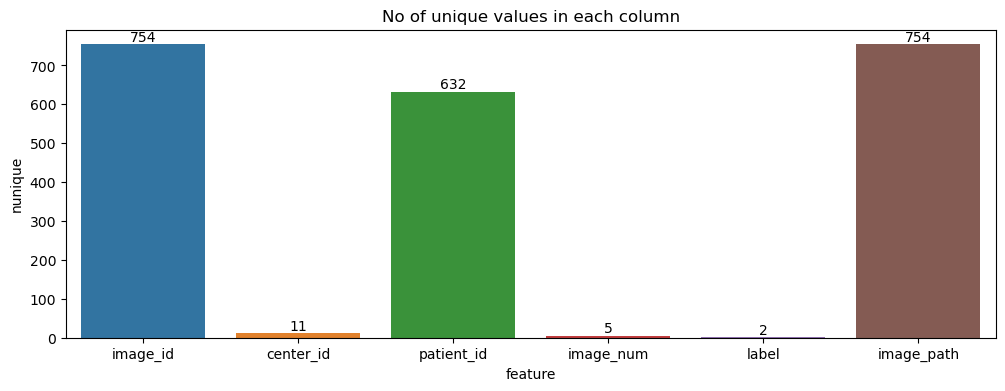

In [16]:
## No of unique values in each column
print('Unique Values for: ')
train_df.nunique()

print('\n')

nu = train_df.nunique().reset_index()
nu.columns = ['feature','nunique']
plt.figure(figsize=(12,4))
ax = sns.barplot(x='feature', y='nunique', data=nu)
ax.bar_label(ax.containers[0])
ax.set_title('No of unique values in each column')

In [17]:
train_df['center_id'].value_counts()

11    257
4     114
7      99
1      54
3      49
10     44
5      38
6      38
2      29
8      16
9      16
Name: center_id, dtype: int64

<AxesSubplot:xlabel='center_id', ylabel='count'>

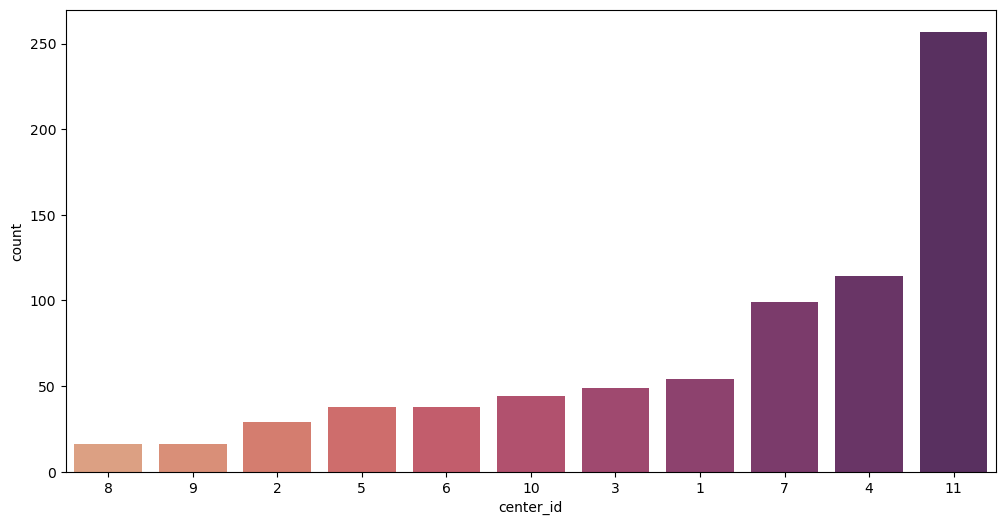

In [18]:
plt.figure(figsize=(12,6))
sns.countplot(data=train_df, x='center_id', palette='flare', order=train_df['center_id'].value_counts(ascending=True).index)

Take note of the min and max values for number of slides per patient

In [19]:
train_df['patient_id'].value_counts()

91b9d3    5
3d10be    5
09644e    5
56d177    5
4f6fb1    4
         ..
623f89    1
14d2fa    1
615d87    1
611a50    1
006388    1
Name: patient_id, Length: 632, dtype: int64

In [20]:
train_df['patient_id'].value_counts().describe()


count    632.000000
mean       1.193038
std        0.557970
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        5.000000
Name: patient_id, dtype: float64

In [21]:
train_df[train_df['patient_id']=='3d10be']

,image_id,center_id,patient_id,image_num,label,image_path
184,3d10be_0,4,3d10be,0,CE,../input/mayo-clinic-strip-ai/train/3d10be_0.tif
185,3d10be_1,4,3d10be,1,CE,../input/mayo-clinic-strip-ai/train/3d10be_1.tif
186,3d10be_2,4,3d10be,2,CE,../input/mayo-clinic-strip-ai/train/3d10be_2.tif
187,3d10be_3,4,3d10be,3,CE,../input/mayo-clinic-strip-ai/train/3d10be_3.tif
188,3d10be_4,4,3d10be,4,CE,../input/mayo-clinic-strip-ai/train/3d10be_4.tif


<AxesSubplot:xlabel='image_num', ylabel='count'>

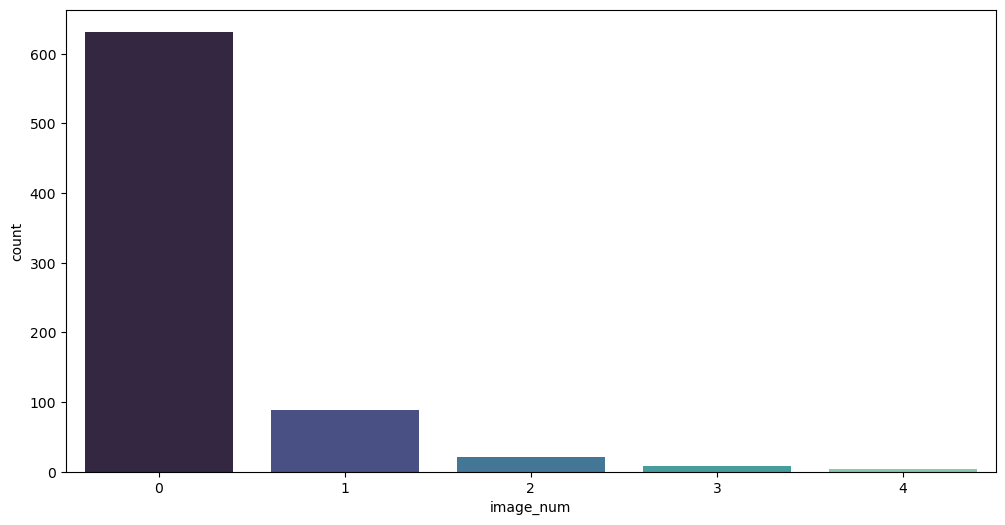

In [22]:
plt.figure(figsize=(12,6))
sns.countplot(data=train_df, x='image_num', order=train_df['image_num'].value_counts().index, palette='mako')

 **Most patients have only 1 image**

In [23]:
d=train_df['label'].value_counts().reset_index()
d['percentage']=d['label'].apply(lambda x: (x/sum(train_df['label'].value_counts()))*100)
d

,index,label,percentage
0,CE,547,72.546419
1,LAA,207,27.453581


In [24]:
d=d.rename({'index': 'label', 'label': 'count'}, axis='columns')
d

,label,count,percentage
0,CE,547,72.546419
1,LAA,207,27.453581


<AxesSubplot:xlabel='label', ylabel='count'>

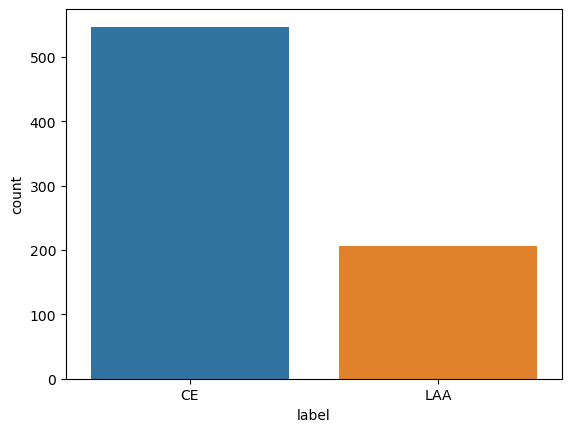

In [25]:
sns.countplot(data=train_df, x='label')

Unbalanced Dataset, CE makes up ~73% of the entire dataset
We can use data augmentation on the image dataset for deep learning.

**Reading a sample TIF image**

In [26]:
from PIL import Image

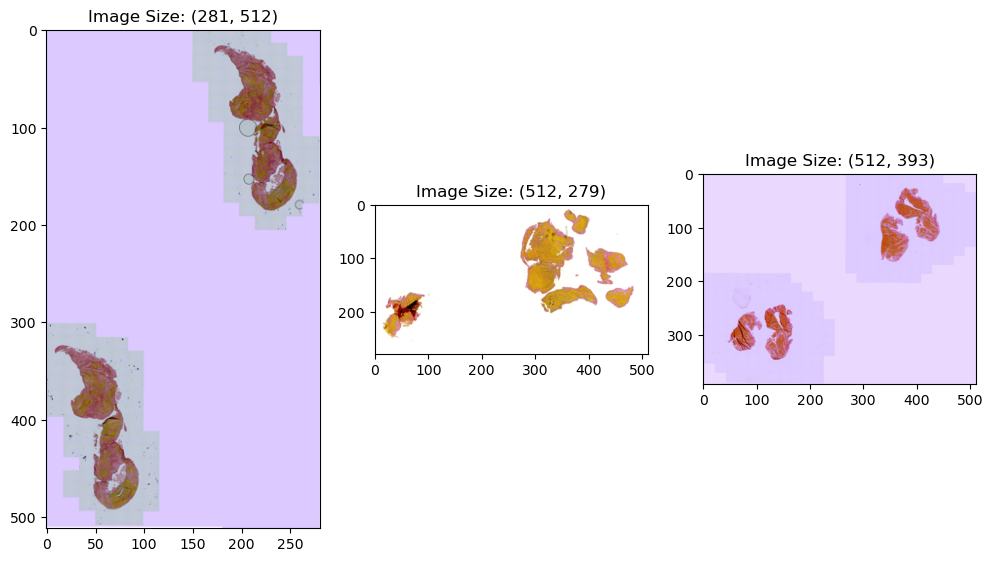

CPU times: user 35.8 s, sys: 8.07 s, total: 43.8 s
Wall time: 52 s


In [27]:
%%time
Image.MAX_IMAGE_PIXELS = None
size = (512,512)


sample_slides = train_df.sample(n=3, random_state=1) 
fig, axs = plt.subplots(1, 3, figsize = (12, 12))

for i in range(len(sample_slides.index)): 
    
    slide = Image.open(sample_slides.iloc[i]['image_path'])
    slide.thumbnail(size)
    axs[i].set_title(f'Image Size: {slide.size}')
    axs[i].imshow(slide)

plt.show()

In [28]:
train_images = glob("/kaggle/input/mayo-clinic-strip-ai/train/*")
test_images = glob("/kaggle/input/mayo-clinic-strip-ai/test/*")
other_images = glob("/kaggle/input/mayo-clinic-strip-ai/other/*")
print(f"Number of images in a training set: {len(train_images)}")
print(f"Number of images in a training set: {len(test_images)}")
print(f"Number of other: {len(other_images)}")

Number of images in a training set: 754
Number of images in a training set: 4
Number of other: 396


In [29]:
img_prop = defaultdict(list)
for i, path in enumerate(train_images):
    img_path = train_images[i]
    slide = OpenSlide(img_path)    
    img_prop['image_id'].append(img_path[-12:-4])
    img_prop['width'].append(slide.dimensions[0])
    img_prop['height'].append(slide.dimensions[1])
    img_prop['size'].append(round(os.path.getsize(img_path) / 1e6, 2))
    img_prop['path'].append(img_path)
image_data = pd.DataFrame(img_prop)
image_data['img_aspect_ratio'] = image_data['width']/image_data['height']
image_data.sort_values(by='image_id', inplace=True)
image_data.reset_index(inplace=True, drop=True)
image_data = image_data.merge(train_df, on='image_id')
image_data.head()

,image_id,width,height,size,path,img_aspect_ratio,center_id,patient_id,image_num,label,image_path
0,006388_0,34007,60797,1312.94,/kaggle/input/mayo-clinic-strip-ai/train/00638...,0.559353,11,006388,0,CE,../input/mayo-clinic-strip-ai/train/006388_0.tif
1,008e5c_0,5946,29694,109.57,/kaggle/input/mayo-clinic-strip-ai/train/008e5...,0.200242,11,008e5c,0,CE,../input/mayo-clinic-strip-ai/train/008e5c_0.tif
2,00c058_0,15255,61801,351.76,/kaggle/input/mayo-clinic-strip-ai/train/00c05...,0.246841,11,00c058,0,LAA,../input/mayo-clinic-strip-ai/train/00c058_0.tif
3,01adc5_0,55831,26553,679.17,/kaggle/input/mayo-clinic-strip-ai/train/01adc...,2.102625,11,01adc5,0,LAA,../input/mayo-clinic-strip-ai/train/01adc5_0.tif
4,026c97_0,10533,8267,61.21,/kaggle/input/mayo-clinic-strip-ai/train/026c9...,1.274102,4,026c97,0,CE,../input/mayo-clinic-strip-ai/train/026c97_0.tif


In [30]:
def reading_tiff(image):
    Reading_Image = cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB)
    return Reading_Image

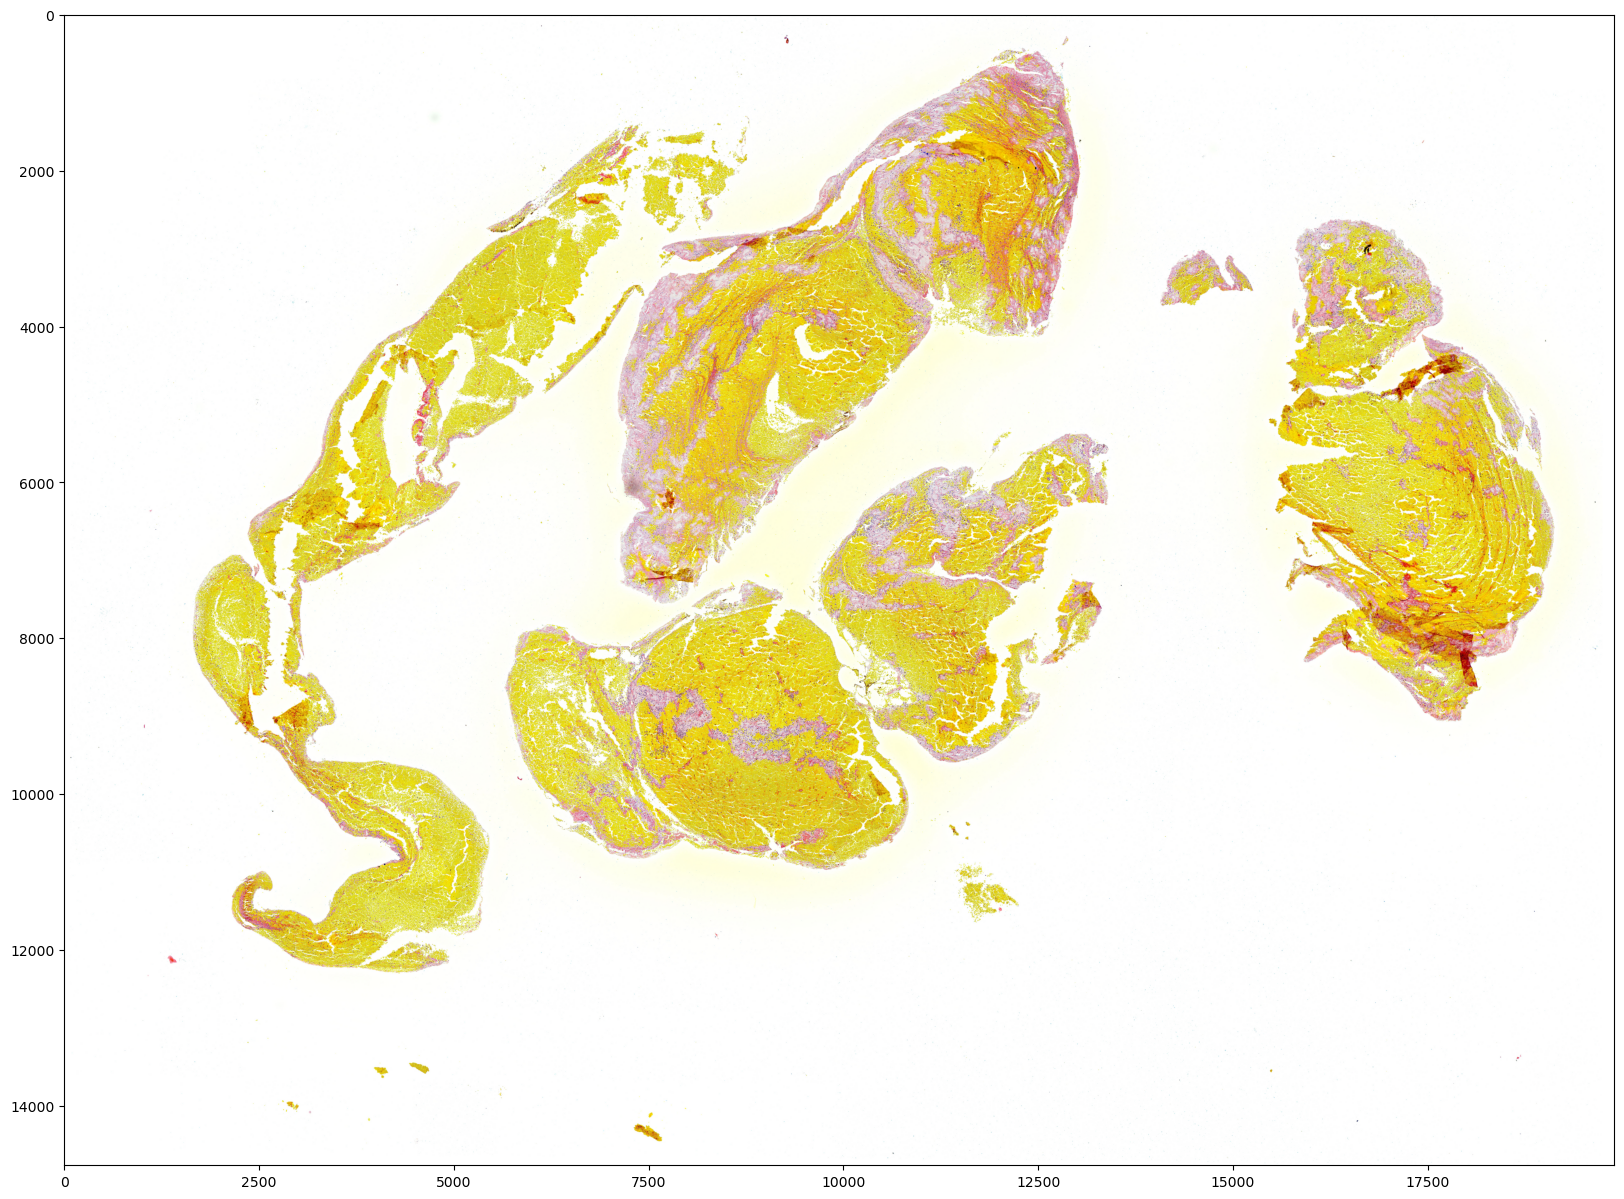

In [31]:
Reading_Image=reading_tiff('../input/mayo-clinic-strip-ai/train/31adaa_0.tif')
figure = plt.figure(figsize=(20,20))
plt.imshow(Reading_Image)

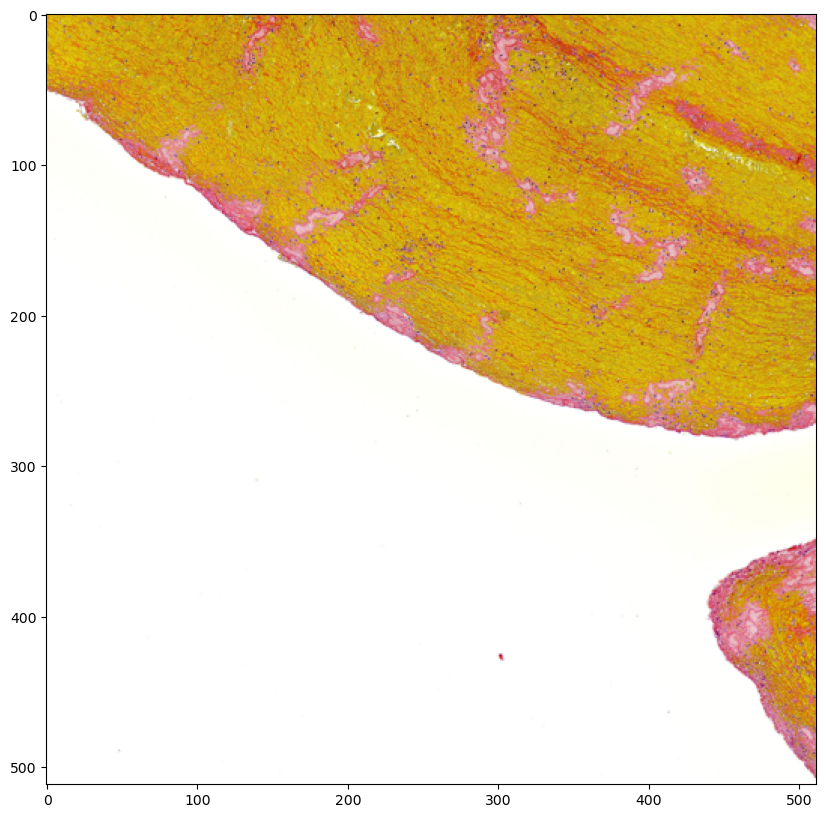

In [32]:
slide = OpenSlide('/kaggle/input/mayo-clinic-strip-ai/train/026c97_0.tif') # opening a full slide

region = (2500, 2000) # location of the top left pixel
level = 0 # level of the picture (we have only 0)
size = (3500, 3500) # region size in pixels

region = slide.read_region(region, level, size)
image = region.resize((512, 512))
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

In [33]:
import plotly.express as px
continuous_color_scheme = px.colors.sequential.Sunset
discrete_color_scheme = px.colors.qualitative.Pastel1
# opacity
plots_opacity = 0.8

In [34]:
import plotly.express as px
# Q: Which center is the most polular one?
# A: 11
# some centers have only 20-30 images taken
# all centers have data of both classes

# distribution over centers
distribution_over_classes = train_df['center_id'].value_counts().reset_index().rename(columns={'index':'Center', 'center_id':'Count'})
fig = px.bar(distribution_over_classes, x="Center", y="Count", title='Comparison of number of examples in test dataset by Center'
             , text='Count', color = 'Center', 
             color_continuous_scale= continuous_color_scheme
             )  
             #color_discrete_sequence = generate_color_sequence(2) )#cmocean.cm.thermal)
fig.update_traces(texttemplate='%{text:.0s}', textposition='outside') # prints values above bars
fig.show()

# distribution over centers and classes 
fig = px.bar(train_df.groupby(by=['center_id', 'label'], as_index=False).count().rename(columns={'image_id':'Count'}), x="center_id", y="Count", 
             color="label", 
             title="Data distribution over centers and labels",  
             color_discrete_sequence=discrete_color_scheme,
             opacity=plots_opacity
             )
fig.show()

# the same data can be shown as sunburst plot
fig = px.sunburst(train_df[['center_id', 'label', 'image_id']].groupby(by=['center_id', 'label'], as_index=False).count().rename(columns={'image_id':'Count'}),
                  path=['center_id', 'label'], values='Count', color_discrete_sequence=discrete_color_scheme)
fig.show()
plt.show()

<AxesSubplot:ylabel='label'>

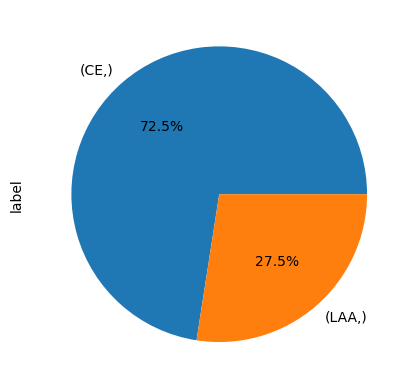

In [35]:
train_df[["label"]].value_counts().plot.pie(autopct='%1.1f%%',ylabel="label")

In [36]:
print('Unique patients having CE condition', train_df.loc[train_df['label']=='CE']['patient_id'].nunique() , 'of total',train_df['patient_id'].nunique() )
print('Unique patients having LAA condition', train_df.loc[train_df['label']=='LAA']['patient_id'].nunique(),'of total',train_df['patient_id'].nunique() )

Unique patients having CE condition 457 of total 632
Unique patients having LAA condition 175 of total 632


In [37]:
train_df.groupby(['patient_id']).agg(distinct_condition=('label','nunique')).reset_index()['distinct_condition'].value_counts() 

# None of the patients presented with both conditions

1    632
Name: distinct_condition, dtype: int64

## **Model training**

In [38]:
train_df["file_path"] = train_df["image_id"].apply(lambda x: "../input/mayo-clinic-strip-ai/train/" + x + ".tif")
test_df["file_path"]  = test_df["image_id"].apply(lambda x: "../input/mayo-clinic-strip-ai/test/" + x + ".tif")

In [39]:
# labelling CE class as 1 and LAA as 0
train_df["target"] = train_df["label"].apply(lambda x : 1 if x=="CE" else 0)
train_df.head()

,image_id,center_id,patient_id,image_num,label,image_path,file_path,target
0,006388_0,11,006388,0,CE,../input/mayo-clinic-strip-ai/train/006388_0.tif,../input/mayo-clinic-strip-ai/train/006388_0.tif,1
1,008e5c_0,11,008e5c,0,CE,../input/mayo-clinic-strip-ai/train/008e5c_0.tif,../input/mayo-clinic-strip-ai/train/008e5c_0.tif,1
2,00c058_0,11,00c058,0,LAA,../input/mayo-clinic-strip-ai/train/00c058_0.tif,../input/mayo-clinic-strip-ai/train/00c058_0.tif,0
3,01adc5_0,11,01adc5,0,LAA,../input/mayo-clinic-strip-ai/train/01adc5_0.tif,../input/mayo-clinic-strip-ai/train/01adc5_0.tif,0
4,026c97_0,4,026c97,0,CE,../input/mayo-clinic-strip-ai/train/026c97_0.tif,../input/mayo-clinic-strip-ai/train/026c97_0.tif,1


## **Preprocessing¶**

In [40]:
%%time
def preprocess(image_path):
    slide=OpenSlide(image_path)
    region= (2500,2500)    
    size  = (5000, 5000)
    image = slide.read_region(region, 0, size)
    image = image.resize((128, 128))
    image = np.array(image)    
    return image

X_train=[]
for i in tqdm(train_df['file_path']):
    x1=preprocess(i)
    X_train.append(x1)

Y_train=[]    
Y_train=train_df['target']

100%|██████████| 754/754 [52:31<00:00,  4.18s/it] 

CPU times: user 18min 43s, sys: 3min 19s, total: 22min 2s
Wall time: 52min 31s


In [41]:
X_train=np.array(X_train)
X_train=X_train/255.0
Y_train = np.array(Y_train)

In [42]:
## Splitting data
x_train,x_test,y_train,y_test=train_test_split(X_train,Y_train, test_size=0.2, random_state=42)

In [43]:
## Splitting data
x_train,x_test,y_train,y_test=train_test_split(X_train,Y_train, test_size=0.2, random_state=42)

## **CNN approach**

In [44]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [45]:
from keras import metrics

model = Sequential()
input_shape = (128, 128, 4)

model.add(Conv2D(filters=64, kernel_size = (3,3), padding = 'valid', activation = 'relu', input_shape = input_shape))
model.add(MaxPooling2D())
model.add(Conv2D(filters=64, kernel_size = (3,3), strides =2, padding = 'valid', activation = 'relu'))
model.add(Conv2D(filters=64, kernel_size = (3,3), strides =2, padding = 'valid', activation = 'relu'))
model.add(Conv2D(filters=64, kernel_size = (3,3), strides =2, padding = 'valid', activation = 'relu'))
model.add(Conv2D(filters=128, kernel_size = (3,3), strides =2, padding = 'valid', activation = 'relu'))
model.add(Conv2D(filters=128, kernel_size = (3,3), strides =2, padding = 'valid', activation = 'relu'))

model.add(Dropout(0.13))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.13))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(50, activation = 'relu'))
model.add(Dense(1 , activation="sigmoid"))

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics=[metrics.binary_accuracy,f1_score],
    optimizer = tf.keras.optimizers.Adam(1e-3))

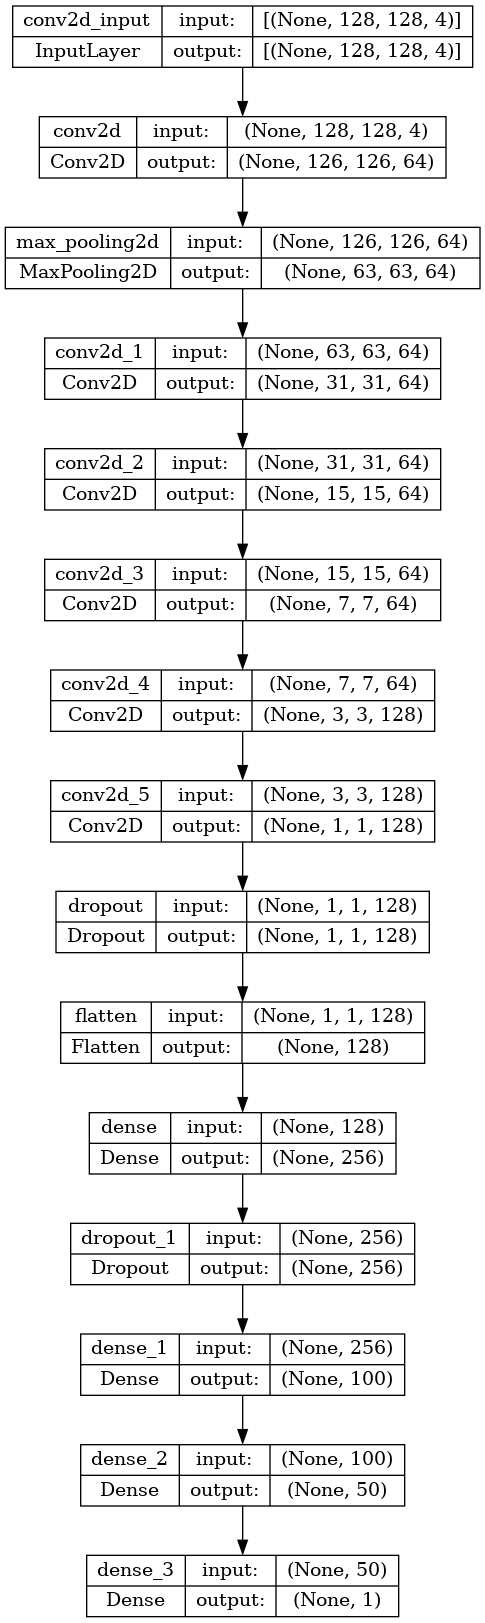

In [46]:
dot_img_file = 'model.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [47]:
## This is where we balance class weights
from sklearn.utils import compute_class_weight
train_classes = Y_train
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_classes),
                                        y = train_classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_classes), class_weights))
class_weights

{0: 1.821256038647343, 1: 0.6892138939670932}

## Training the model

In [48]:
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='our_cnn_best.h5',
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True, verbose=1)

In [49]:
model.fit(
    x_train,
    y_train,
    epochs = 10,
    batch_size=20,
    validation_data = (x_test,y_test),
    class_weight= class_weights,
    callbacks = callback
)

Epoch 1/10


2024-04-12 14:51:29.207687: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


31/31 [==============================] - ETA: 0s - loss: 0.6862 - binary_accuracy: 0.6882 - f1_score: 0.7590
Epoch 1: val_binary_accuracy improved from -inf to 0.32450, saving model to our_cnn_best.h5
31/31 [==============================] - 14s 45ms/step - loss: 0.6862 - binary_accuracy: 0.6882 - f1_score: 0.7590 - val_loss: 0.6938 - val_binary_accuracy: 0.3245 - val_f1_score: 0.0000e+00
Epoch 2/10
28/31 [==========================>...] - ETA: 0s - loss: 0.6789 - binary_accuracy: 0.3321 - f1_score: 0.1318
Epoch 2: val_binary_accuracy improved from 0.32450 to 0.67550, saving model to our_cnn_best.h5
31/31 [==============================] - 1s 20ms/step - loss: 0.6842 - binary_accuracy: 0.3549 - f1_score: 0.1954 - val_loss: 0.6897 - val_binary_accuracy: 0.6755 - val_f1_score: 0.8073
Epoch 3/10
30/31 [============================>.] - ETA: 0s - loss: 0.6829 - binary_accuracy: 0.7383 - f1_score: 0.8458
Epoch 3: val_binary_accuracy did not improve from 0.67550
31/31 [======================

In [50]:
best_cnn = load_model('/kaggle/working/our_cnn_best.h5', custom_objects={"f1_score": f1_score })
best_cnn.evaluate(x_test,y_test)

5/5 [==============================] - 1s 35ms/step - loss: 0.6897 - binary_accuracy: 0.6755 - f1_score: 0.8036


[0.6897422671318054, 0.6754966974258423, 0.8035913705825806]

5/5 [==============================] - 0s 6ms/step


Text(0.5, 25.722222222222214, 'Actual')

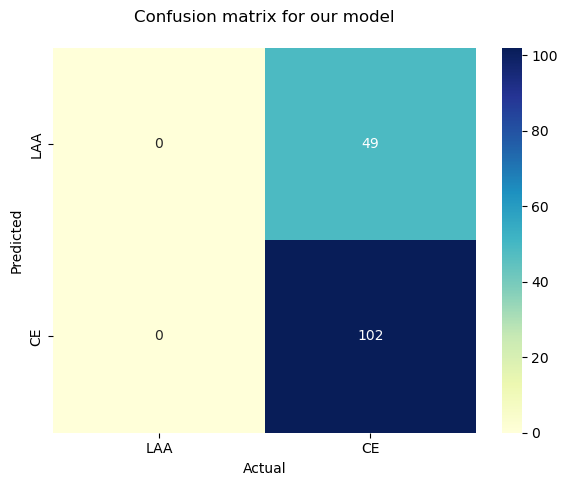

In [51]:
# Plot confusion matrices for benchmark and transfer learning models
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(15, 5))

preds = best_cnn.predict(x_test)
preds = (preds >= 0.5).astype(np.int32)

cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm, index=['LAA', 'CE'], columns=['LAA', 'CE'])
plt.subplot(121)
plt.title("Confusion matrix for our model\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

In [52]:
test1=[]
for i in test_df['file_path']:
    x1=preprocess(i)
    test1.append(x1)
    print(i)
    
test1=np.array(test1)

../input/mayo-clinic-strip-ai/test/006388_0.tif
../input/mayo-clinic-strip-ai/test/008e5c_0.tif
../input/mayo-clinic-strip-ai/test/00c058_0.tif
../input/mayo-clinic-strip-ai/test/01adc5_0.tif


In [53]:
cnn_pred=model.predict(test1)4
cnn_pred

1/1 [==============================] - 0s 220ms/step


array([[0.4743243 ],
       [0.46802136],
       [0.47489238],
       [0.47488236]], dtype=float32)

In [54]:
sub = pd.DataFrame(test_df["patient_id"].copy())
sub["CE"] = cnn_pred
sub["LAA"] = 1- sub["CE"]

sub = sub.groupby("patient_id").mean()
sub = sub[["CE", "LAA"]].round(6).reset_index()
sub

,patient_id,CE,LAA
0,006388,0.474324,0.525676
1,008e5c,0.468021,0.531979
2,00c058,0.474892,0.525108
3,01adc5,0.474882,0.525118


In [55]:
sub.to_csv("submission.csv", index = False)
!head submission.csv

patient_id,CE,LAA
006388,0.474324,0.525676
008e5c,0.468021,0.531979
00c058,0.474892,0.525108
01adc5,0.474882,0.525118
